In [ ]:
import numpy as np
import nibabel as nib
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def gaussian_pdf_1d(x, mu, var):
    return 1.0 / np.sqrt(2 * np.pi * (var + 1e-6)) * np.exp(-0.5 * ((x - mu)**2) / (var + 1e-6))

def E_step(X, means, variances, pis):
    N = X.shape[0]
    K = len(means)
    pdfs = np.zeros((N, K))
    for k in range(K):
        pdfs[:, k] = gaussian_pdf_1d(X.flatten(), means[k], variances[k])
    weighted_pdfs = pdfs * pis
    gamma = weighted_pdfs / np.maximum(weighted_pdfs.sum(axis=1, keepdims=True), 1e-6)
    return gamma

def M_step(X, gamma):
    N = X.shape[0]
    K = gamma.shape[1]
    Nk = np.sum(gamma, axis=0)
    
    # Avoid division by zero
    Nk = np.maximum(Nk, 1e-6)

    means = np.sum(gamma * X, axis=0) / Nk
    variances = []
    for k in range(K):
        diff = X.flatten() - means[k]
        var_k = np.sum(gamma[:, k] * (diff**2)) / Nk[k]
        variances.append(np.maximum(var_k, 1e-3))  # Prevent collapse
    pis = Nk / N
    return means, variances, pis

def gmm(X, K, iterations=1000, tol=1e-7):
    N = X.shape[0]
    
    # Normalize X
    # X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-6)
    X_mean, X_std = np.mean(X), np.std(X)
    X = (X - X_mean) / (X_std + 1e-6)

    # kmeans = KMeans(n_clusters=K).fit(X)
    # means = kmeans.cluster_centers_.flatten()
    # labels_km = kmeans.labels_
    
    nonzero_X = X[X > 0]
    min_intensity, max_intensity = np.min(nonzero_X), np.max(nonzero_X)
    means = np.linspace(min_intensity, max_intensity, K)


    # variances = []
    # pis = []
    # for k in range(K):
    #     cluster_data = X[labels_km == k, 0]
    #     variance = np.var(cluster_data) if len(cluster_data) > 0 else np.var(X)
    #     variances.append(np.maximum(variance, 1e-6))
    #     pis.append(len(cluster_data) / float(N))

    variances = np.full(K, np.var(X))  # Start with the full variance
    pis = np.full(K, 1.0 / K)  # Equal priors

    
    print("\n[DEBUG] Initial values:")
    print("Means:", means)
    print("Variances:", variances)
    print("Priors (pis):", pis)
    
    log_likelihoods = []
    for i in tqdm(range(iterations), desc="GMM iterations"):
        gamma = E_step(X, means, variances, pis)
        means, variances, pis = M_step(X, gamma)

        pdfs = np.zeros((N, K))
        for k in range(K):
            pdfs[:, k] = gaussian_pdf_1d(X.flatten(), means[k], variances[k])
        weighted_pdfs = pdfs * pis
        ll = np.sum(np.log(np.maximum(weighted_pdfs.sum(axis=1), 1e-6)))  # Avoid log(0)
        log_likelihoods.append(ll)
        
        if i % 10 == 0:
            print(f"\n[DEBUG] Iteration {i}:")
            print("Means:", means)
            print("Variances:", variances)
            print("Priors (pis):", pis)

        if i > 0 and np.abs(ll - log_likelihoods[-2]) < tol:
            print("[DEBUG] Convergence reached.")
            break

    return means, variances, pis, gamma, log_likelihoods

img_file = 'data/sald_031764_img.nii'
img = nib.load(img_file)
data = img.get_fdata()
affine = img.affine
header = img.header
print("Loaded brain image with shape:", data.shape)

X = data.flatten()[:, np.newaxis]

means, variances, pis, gamma, log_likelihoods = gmm(X, K=4, iterations=1000)
labels = np.argmax(gamma, axis=1)
# 0 62 102; 0 827 80; 0.7 0.18 0.1; csf gray white
sorted_indices = np.argsort(means)
mapping = {sorted_indices[i]: i for i in range(4)}

gmm_labels = np.vectorize(lambda x: mapping[x])(labels)
gmm_segmentation = gmm_labels.reshape(data.shape)

plt.figure(figsize=(10, 5))
plt.hist(gmm_labels.flatten(), bins=4, alpha=0.7, label="GMM Segmentation")
plt.xlabel("Segmented Class")
plt.ylabel("Voxel Count")
plt.title("Histogram of Segmentation Labels")
plt.legend()
plt.show()

prob_csf_file   = 'data/sald_031764_probmask_csf.nii'
prob_gray_file  = 'data/sald_031764_probmask_graymatter.nii'
prob_white_file = 'data/sald_031764_probmask_whitematter.nii'

prob_csf   = nib.load(prob_csf_file).get_fdata()
prob_gray  = nib.load(prob_gray_file).get_fdata()
prob_white = nib.load(prob_white_file).get_fdata()

probs = np.stack([prob_csf, prob_gray, prob_white], axis=-1)
gt_segmentation = np.argmax(probs, axis=-1)

accuracy = np.mean(gmm_segmentation == gt_segmentation) * 100
print("Pointwise accuracy of the segmentation: {:.2f}%".format(accuracy))

gmm_seg_img = nib.Nifti1Image(gmm_segmentation.astype(np.int16), affine, header)
gt_seg_img  = nib.Nifti1Image(gt_segmentation.astype(np.int16), affine, header)

nib.save(gmm_seg_img, 'gmm_segmentation.nii')
nib.save(gt_seg_img, 'ground_truth_segmentation.nii')



Loaded brain image with shape: (182, 218, 182)

[DEBUG] Initial values:
Means: [0.01035899 1.51856804 3.02677709 4.53498615]
Variances: [0.99999995 0.99999995 0.99999995 0.99999995]
Priors (pis): [0.25 0.25 0.25 0.25]


GMM iterations:   0%|          | 1/1000 [00:02<37:16,  2.24s/it]


[DEBUG] Iteration 0:
Means: [-0.43917908  0.77072962  1.87287051  2.09420256]
Variances: [np.float64(0.2412622689676768), np.float64(1.278172358684235), np.float64(0.2598025373558189), np.float64(0.10055490343323674)]
Priors (pis): [0.70288362 0.22572397 0.06682504 0.00456736]


GMM iterations:   0%|          | 3/1000 [00:06<37:46,  2.27s/it]

In [2]:
unique, counts = np.unique(gmm_labels, return_counts=True)
print("Segmented class distribution:", dict(zip(unique, counts)))


Segmented class distribution: {np.int64(0): np.int64(5148583), np.int64(1): np.int64(362482), np.int64(2): np.int64(1272303), np.int64(3): np.int64(437664)}


In [3]:
print("Final cluster means:", means)

Final cluster means: [-0.58372404  0.2109939   1.55929758  2.24665855]


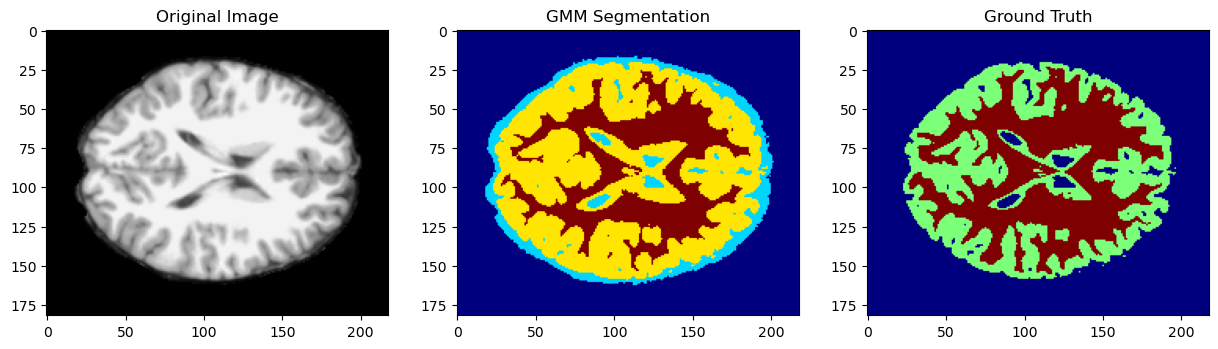

In [4]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(data[:, :, data.shape[2] // 2], cmap="gray")
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(gmm_segmentation[:, :, data.shape[2] // 2], cmap="jet")
plt.title("GMM Segmentation")

plt.subplot(1, 3, 3)
plt.imshow(gt_segmentation[:, :, data.shape[2] // 2], cmap="jet")
plt.title("Ground Truth")

plt.show()


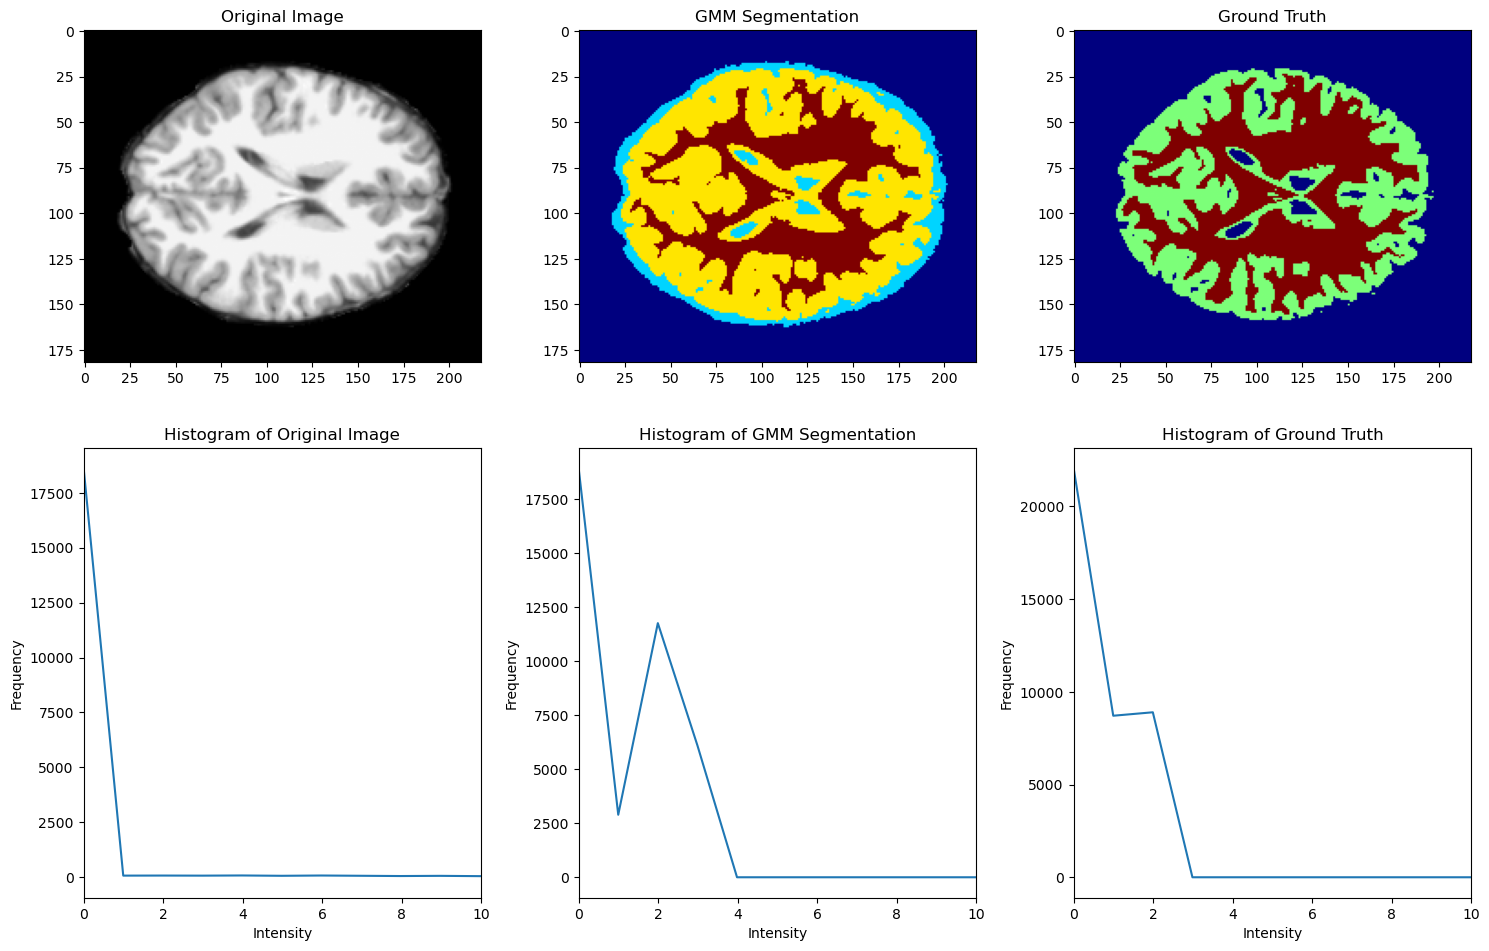

In [5]:
original_image = data[:, :, data.shape[2] // 2]
gmm_image = gmm_segmentation[:, :, data.shape[2] // 2]
gt_image = gt_segmentation[:, :, data.shape[2] // 2]

hist_original, bin_edges = np.histogram(original_image, bins=256, range=(0, 255))
hist_gmm, _ = np.histogram(gmm_image, bins=256, range=(0, 255))
hist_gt, _ = np.histogram(gt_image, bins=256, range=(0, 255))

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(original_image, cmap="gray")
axs[0, 0].set_title("Original Image")

axs[0, 1].imshow(gmm_image, cmap="jet")
axs[0, 1].set_title("GMM Segmentation")

axs[0, 2].imshow(gt_image, cmap="jet")
axs[0, 2].set_title("Ground Truth")

# axs[1, 0].plot(bin_edges[:-1], hist_original)
# axs[1, 0].set_title("Histogram of Original Image")
# axs[1, 0].set_xlabel("Intensity")
# axs[1, 0].set_ylabel("Frequency")

# axs[1, 1].plot(bin_edges[:-1], hist_gmm)
# axs[1, 1].set_title("Histogram of GMM Segmentation")
# axs[1, 1].set_xlabel("Intensity")
# axs[1, 1].set_ylabel("Frequency")

# axs[1, 2].plot(bin_edges[:-1], hist_gt)
# axs[1, 2].set_title("Histogram of Ground Truth")
# axs[1, 2].set_xlabel("Intensity")
# axs[1, 2].set_ylabel("Frequency")

# max_intensity = 10
# axs[1, 0].set_xlim(0, max_intensity)
# axs[1, 1].set_xlim(0, max_intensity)
# axs[1, 2].set_xlim(0, max_intensity)


plt.tight_layout()
plt.show()



Misclassification Regions

By looking at the Gaussian distributions and brain tissue segmentation:

#### Misclassification Occurs at Boundaries

- The CSF (cerebrospinal fluid), gray matter, and white matter intensities overlap in MRI scans.
- GMM assumes each class follows a normal distribution, but real tissue distributions may not be perfectly Gaussian.
- Boundaries between tissues have partial volume effects, where a voxel contains a mix of two or more tissue types.

#### Misclassification in Low-Contrast Areas

- If two Gaussians (e.g., gray and white matter) are close together, GMM struggles to separate them cleanly.
- Low contrast regions—such as deep gray matter—can cause white matter and gray matter misclassification.

#### CSF Misclassification
- CSF usually has very low intensity in T1-weighted MRI.

If there's noise or artifacts, GMM may assign some CSF voxels to gray matter or vice versa.
This is because the mean intensity of CSF might be close to darker parts of gray matter.